
## Loading packages

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score,confusion_matrix,precision_score,recall_score,precision_recall_curve
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=UserWarning)

## Loading Data

In [125]:
df=pd.read_csv('datasets/churn_prediction_project.csv')

### Missing Values
Before we go on to build the model, we must look for missing values within the dataset as treating the missing values  is a necessary step before we fit a logistic regression model on the dataset.

In [128]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [130]:
df.gender.value_counts()

gender
Male      16548
Female    11309
Name: count, dtype: int64

In [132]:
dict_gender={'Male':1,'Female':0}
df.replace({'gender':dict_gender},inplace=True)
df['gender']=df['gender'].fillna(-1)
            
            

In [134]:
df.dependents.value_counts()

dependents
0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
9.0         1
52.0        1
36.0        1
50.0        1
8.0         1
25.0        1
32.0        1
Name: count, dtype: int64

In [136]:
df.occupation.value_counts()

occupation
self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: count, dtype: int64

In [138]:
df.city.value_counts()

city
1020.0    3479
1096.0    2016
409.0     1334
146.0     1291
834.0     1138
          ... 
748.0        1
1099.0       1
108.0        1
655.0        1
723.0        1
Name: count, Length: 1604, dtype: int64

In [140]:
df['dependents']=df['dependents'].fillna(0)
df['occupation']=df['occupation'].fillna('self_employed')
df['city']=df['city'].fillna(1020)

In [142]:
df.days_since_last_transaction.value_counts()

days_since_last_transaction
0.0      1672
3.0       831
14.0      654
4.0       632
6.0       596
         ... 
309.0       1
225.0       1
183.0       1
92.0        1
334.0       1
Name: count, Length: 360, dtype: int64

In [144]:
df['days_since_last_transaction']=df['days_since_last_transaction'].fillna(1672)

### Preprocessing

Now, before applying linear model such as logistic regression, we need to scale the data and keep all features as numeric strictly. 


### Dummies with Multiple Categories

In [148]:
#convert occupation to one hot encoded features]
df=pd.concat([df,pd.get_dummies(df['occupation'],prefix=str('occupation'),prefix_sep='_')],axis=1)

### Scaling Numerical Features for Logistic Regression

Now, we remember that there are a lot of outliers in the dataset especially when it comes to previous and current balance features. Also, the distributions are skewed for these features if you recall from the EDA. We will take 2 steps to deal with that here:
* Log Transformation
* Standard Scaler

Standard scaling is anyways a necessity when it comes to linear models and we have done that here after doing log transformation on all balance features.

In [151]:
num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i]=np.log(df[i]+17000)
    
    
std=StandardScaler()
scaled=std.fit_transform(df[num_cols])
scaled=pd.DataFrame(scaled,columns=num_cols)
    
    
    
    

In [153]:
df_df_og=df.copy()
df=df.drop(columns=num_cols,axis=1)
df=df.merge(scaled,left_index=True,right_index=True,how='left')





In [155]:
y_all=df.churn
df=df.drop(['churn','customer_id','occupation'],axis=1)


In [157]:
df.head()

,vintage,age,gender,dependents,city,branch_code,days_since_last_transaction,occupation_company,occupation_retired,occupation_salaried,...,current_balance,previous_month_end_balance,average_monthly_balance_prevQ2,average_monthly_balance_prevQ,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance
0,3135,66,1.0,0.0,187.0,755,224.0,False,False,False,...,-0.613738,-0.632367,-0.630646,-0.697612,-0.313931,-0.324487,-0.368251,-0.377390,-0.653455,-0.666207
1,310,35,1.0,0.0,1020.0,3214,60.0,False,False,False,...,0.011267,0.446458,0.949414,0.317595,-0.313852,-0.324410,0.640986,-0.355677,0.149440,0.455680
2,2356,31,1.0,0.0,146.0,41,1672.0,False,False,True,...,-0.209651,0.057975,-0.388637,-0.108263,-0.313841,-0.324400,0.729825,-0.321607,-0.068597,-0.066642
3,478,90,-1.0,0.0,1020.0,582,147.0,False,False,False,...,-0.470836,-0.488530,-0.712855,-0.582976,-0.313872,-0.324429,-0.368193,0.060593,-0.506570,-0.628056
4,2531,42,1.0,2.0,1494.0,388,58.0,False,False,False,...,-0.708214,-0.642441,-0.554058,-0.663399,-0.313902,-0.175104,-0.245463,-0.057927,-0.708257,-0.626732


## Model Building and Evaluation Metrics
Since this is a binary classification problem, we could use the following 2 popular metrics:

1. Recall
2. Area under the Receiver operating characteristic curve


### Baseline Columns

In [161]:
baseline_cols = ['current_month_debit', 'previous_month_debit','current_balance','previous_month_end_balance','vintage'
                 ,'occupation_retired', 'occupation_salaried','occupation_self_employed', 'occupation_student']

In [163]:
df_baseline=df[baseline_cols]

## Train Test Split to create a validation set

In [166]:
xtrain,xtest,ytrain,ytest=train_test_split(df_baseline,y_all,test_size=1/3,random_state=11,stratify=y_all)

In [168]:
model=LogisticRegression()
model.fit(xtrain,ytrain)
pred=model.predict_proba(xtest)

In [170]:
pred

array([[0.85634568, 0.14365432],
       [0.85388461, 0.14611539],
       [0.74427455, 0.25572545],
       ...,
       [0.84132328, 0.15867672],
       [0.75260064, 0.24739936],
       [0.82845898, 0.17154102]])

In [172]:
pred=pred[:,1]

### AUC ROC Curve & Confusion Matrix
Now, let us quickly look at the AUC-ROC curve for our logistic regression model and also the confusion matrix to see where the logistic regression model is failing here.

In [175]:
roc_curve(ytest,pred)

(array([0.00000000e+00, 0.00000000e+00, 2.59470680e-04, ...,
        9.98832382e-01, 9.98832382e-01, 1.00000000e+00]),
 array([0.00000000e+00, 5.70450656e-04, 5.70450656e-04, ...,
        9.99429549e-01, 1.00000000e+00, 1.00000000e+00]),
 array([           inf, 9.98532132e-01, 9.97136921e-01, ...,
        7.30558957e-04, 6.41544158e-04, 7.44972445e-07]))

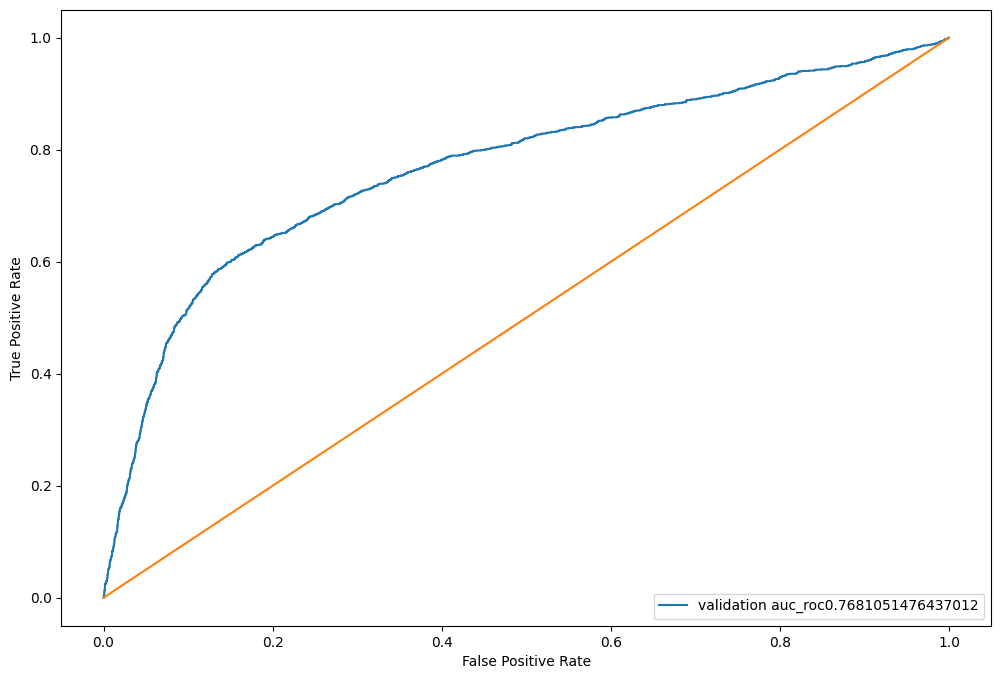

In [177]:
from sklearn.metrics import roc_curve

fpr,tpr,_=roc_curve(ytest,pred)
auc=roc_auc_score(ytest,pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label='validation auc_roc'+str(auc))
x=np.linspace(0,1,1000)
plt.plot(x,x,linestyle='-')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.legend(loc=4)
plt.show()



## confusion matrix

In [180]:
pred_val=model.predict(xtest)

In [182]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(ytest,pred_val)
cm

array([[7593,  115],
       [1550,  203]], dtype=int64)

In [184]:
cm.sum()

9461

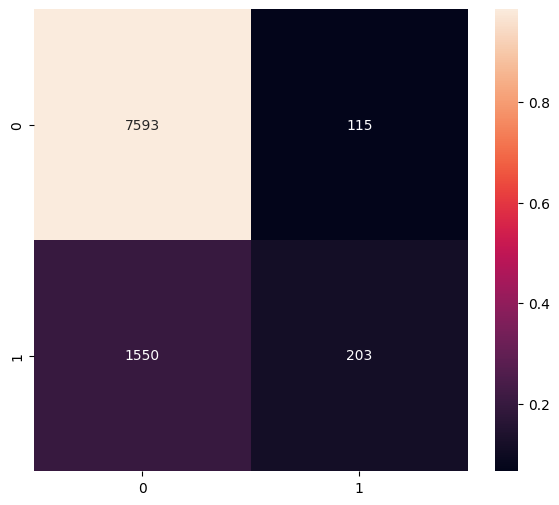

In [186]:
def plot_confusion_matrix(cm,normalized=True,cmap='bone'):
    plt.figure(figsize=(7,6))
    norm_cm=cm
    
    if normalized:
        norm_cm=cm.astype('float')/cm.sum(axis=1)
        sns.heatmap(norm_cm, annot=cm,fmt='g')#, xticklabels=['Predicted: No','Predicted: Yes'], yticklabels=['Actual: No','Actual: Yes'],cmap=cmap)

plot_confusion_matrix(cm, ['No', 'Yes'])

In [188]:
norm_cm=cm.astype('float')/cm.sum(axis=1)
norm_cm

array([[0.98508044, 0.06560183],
       [0.20108978, 0.11580148]])

In [190]:
recall_score(ytest,pred_val)

0.11580148317170565

### Cross validation

In [193]:
def cv_score(ml_model, rstate = 12, thres = 0.5, cols = df.columns):
    i = 1
    cv_scores = []
    df1 = df.copy()
    df1 = df[cols]
    
    # 5 Fold cross validation stratified on the basis of target
    kf = StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl = df1.loc[df_index],df1.loc[test_index]
        ytr,yvl = y_all.loc[df_index],y_all.loc[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        pp = []
         
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
            
         
        # Calculate scores for each fold and print
        pred_val = pp
        roc_score = roc_auc_score(yvl,pred_val)
        recall = recall_score(yvl,pred_val)
        precision = precision_score(yvl,pred_val)
        sufix = ""
        msg = ""
        msg += "ROC AUC Score: {}, Recall Score: {:.4f}, Precision Score: {:.4f} ".format(roc_score, recall,precision)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(roc_score)
        i+=1
    return cv_scores

In [76]:
baseline_scores = cv_score(LogisticRegression(), cols = baseline_cols)


1 of kfold 5
ROC AUC Score: 0.53127725824684, Recall Score: 0.0751, Precision Score: 0.5766 

2 of kfold 5
ROC AUC Score: 0.5338494502106669, Recall Score: 0.0770, Precision Score: 0.6532 

3 of kfold 5
ROC AUC Score: 0.5589481067533253, Recall Score: 0.1350, Precision Score: 0.6425 

4 of kfold 5
ROC AUC Score: 0.5513233978449354, Recall Score: 0.1169, Precision Score: 0.6508 

5 of kfold 5
ROC AUC Score: 0.5460500348652098, Recall Score: 0.1103, Precision Score: 0.5800 


In [78]:
all_feat_scores = cv_score(LogisticRegression())



1 of kfold 5
ROC AUC Score: 0.5379312506422772, Recall Score: 0.0884, Precision Score: 0.6159 

2 of kfold 5
ROC AUC Score: 0.5468964135237899, Recall Score: 0.1074, Precision Score: 0.6420 

3 of kfold 5
ROC AUC Score: 0.5471942551343956, Recall Score: 0.1141, Precision Score: 0.5687 

4 of kfold 5
ROC AUC Score: 0.5595742826318629, Recall Score: 0.1369, Precision Score: 0.6372 

5 of kfold 5
ROC AUC Score: 0.5863111292380965, Recall Score: 0.2072, Precision Score: 0.5767 


### Reverse Feature Elimination or Backward Selection

We have already built a model using all the features and a separate model using some baseline features. We can try using backward feature elimination to check if we can do better. Let's do that next.

In [81]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Create the RFE object and rank each feature
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1, step=1)
rfe.fit(df, y_all)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [82]:
ranking_df = pd.DataFrame()
ranking_df['Feature_name'] = df.columns
ranking_df['Rank'] = rfe.ranking_

In [85]:
ranking_df.head()

,Feature_name,Rank
0,vintage,22
1,age,19
2,gender,15
3,dependents,16
4,city,21


In [87]:
ranking_df['Rank']

0     22
1     19
2     15
3     16
4     21
5     23
6     20
7      8
8      7
9     10
10    11
11     9
12    14
13     1
14    17
15     3
16     2
17    13
18    18
19     6
20    12
21     4
22     5
Name: Rank, dtype: int32

In [89]:
ranked = ranking_df.sort_values(by=['Rank'])

In [91]:
ranked

,Feature_name,Rank
13,current_balance,1
16,average_monthly_balance_prevQ,2
15,average_monthly_balance_prevQ2,3
21,current_month_balance,4
22,previous_month_balance,5
19,current_month_debit,6
8,occupation_retired,7
7,occupation_company,8
11,occupation_student,9
9,occupation_salaried,10


In [93]:
rfe_top_10_scores = cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values)


1 of kfold 5
ROC AUC Score: 0.6047711437673415, Recall Score: 0.2281, Precision Score: 0.7362 

2 of kfold 5
ROC AUC Score: 0.6035839071010173, Recall Score: 0.2234, Precision Score: 0.7581 

3 of kfold 5
ROC AUC Score: 0.6007505887615614, Recall Score: 0.2205, Precision Score: 0.7250 

4 of kfold 5
ROC AUC Score: 0.598288644466957, Recall Score: 0.2139, Precision Score: 0.7377 

5 of kfold 5
ROC AUC Score: 0.5850435650663754, Recall Score: 0.1911, Precision Score: 0.6745 


In [95]:
cv_score(LogisticRegression(), cols = ranked['Feature_name'][:10].values, thres=0.14)


1 of kfold 5
ROC AUC Score: 0.6760050354537046, Recall Score: 0.8298, Precision Score: 0.2832 

2 of kfold 5
ROC AUC Score: 0.6864447641557907, Recall Score: 0.8384, Precision Score: 0.2906 

3 of kfold 5
ROC AUC Score: 0.6833289203625981, Recall Score: 0.8279, Precision Score: 0.2899 

4 of kfold 5
ROC AUC Score: 0.6753522701856407, Recall Score: 0.8213, Precision Score: 0.2842 

5 of kfold 5
ROC AUC Score: 0.6827101451182129, Recall Score: 0.8118, Precision Score: 0.2927 


[0.6760050354537046,
 0.6864447641557907,
 0.6833289203625981,
 0.6753522701856407,
 0.6827101451182129]

### Comparison of Different model fold wise
Let us visualise the cross validation scores for each fold for the following 3 models and observe differences:

Baseline Model
Model based on all features
Model based on top 10 features obtained from RFE

In [98]:
results_df = pd.DataFrame({'baseline':baseline_scores, 'all_feats': all_feat_scores, 'rfe_top_10': rfe_top_10_scores})

<Axes: >

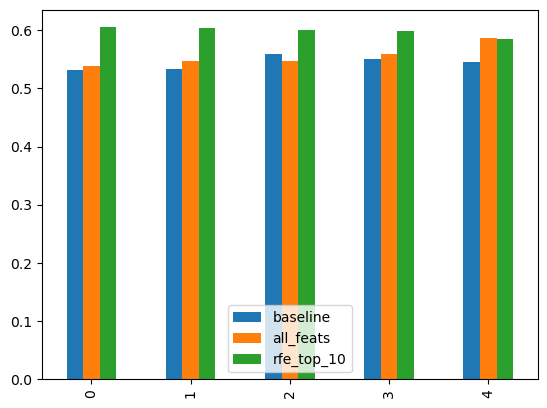

In [100]:
results_df.plot(y=["baseline", "all_feats", "rfe_top_10"], kind="bar")